In [118]:
%reload_ext autoreload
%autoreload 2

import warnings
import numpy as np
import matplotlib.pyplot as plt


from utils import wavei, plot_mesh, parula_map, parula_prev_map
from functools import partial

In [119]:
def heat_fw(T=0.2, plot=True, zlims=None, angle=30):
    L = 1
    T = T
    c = 1
    N = 5
    h = L / N
    M = 10
    k = T / M
    r = c**2 * k / h**2
    
    x = np.arange(0, h + L, h)
    t = np.arange(0, k + T, k)
    
    fn_str = '4*x - 4*x^2'
    f = lambda x: 4*x - 4*x**2
    g1 = g2 = lambda t: np.zeros_like(t)
    
    n = len(x)
    m = len(t)
    
    u = np.zeros((n, m))
    u[1:n-1, 0] = f(x[1:n-1])
    u[0,:] = g1(t)
    u[n-1,:] = g2(t)
    
    for j in range(m-1):
        for i in range(1, n-1):
            u[i, j+1] = (1 - 2*r) * u[i, j] + r * (u[i + 1, j] + u[i - 1, j])
    
    if plot:
        plt.figure()
        plt.plot(x, f(x))
        plt.title(f'fx = {fn_str}', fontsize=16)
        
        plt.figure()
        wavei(u.T, x, t, shading='nearest')
        plt.xlabel('t', fontsize=14)
        plt.ylabel('x', fontsize=14)
        plt.title(f'Forward Euler - r = {r:.4f}', fontsize=16)
        
        T, X = np.meshgrid(t, x)
        
        
        for mode in ['surf', 'mesh']:
            fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8, 8))
            plot_fn = ax.plot_surface if mode=='surf' else partial(plot_mesh, ax=ax)
            dn = np.floor(n/10)
            plot_fn(T, X, u, cmap='jet')
            plt.xlabel('t', fontsize=14)
            plt.ylabel('x', fontsize=14)
            plt.title(f'Forward Euler - r = {r:.4f}', fontsize=16)
            ax.set_xlim(t.min(), t.max())
            ax.set_ylim(x.min(), x.max())
            ax.set_zlim([u.min(), u.max()] if zlims is None else zlims)
            ax.view_init(angle, 225)
            
    

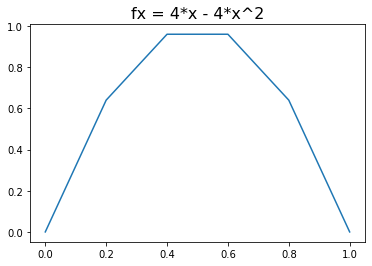

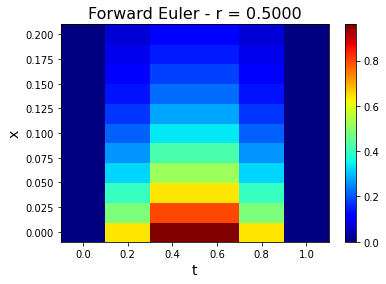

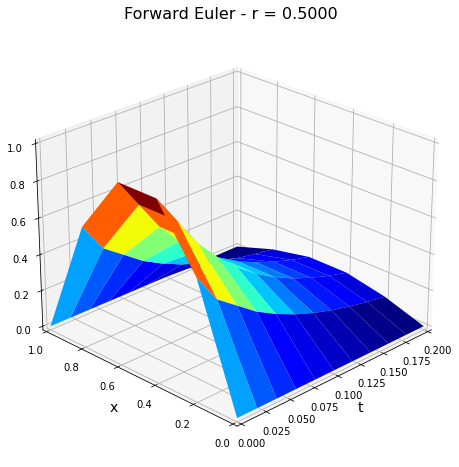

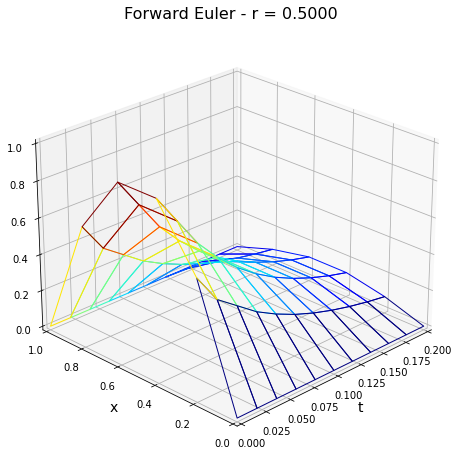

In [120]:
heat_fw(zlims=[0, 1], angle=25)

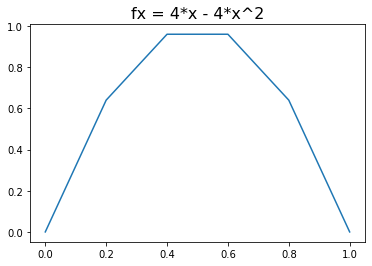

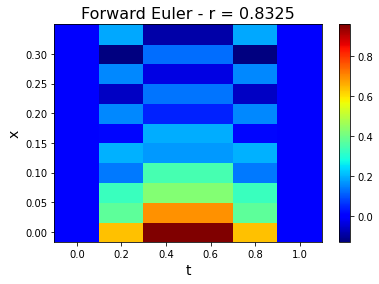

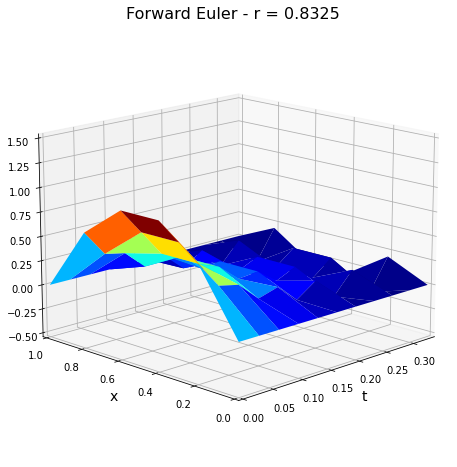

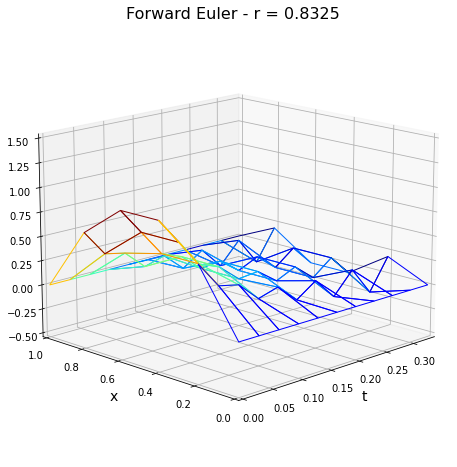

In [121]:
heat_fw(T=0.333, zlims=[-0.5, 1.5], angle=15)

In [122]:
def lu_tri(a, b, c):
    n = len(a)
    alf = np.zeros(n)
    bet = alf.copy()
    alf[0] = a[0]
    for k in range(1, n):
        bet[k] = b[k] / alf[k-1]
        alf[k] = a[k] - bet[k] * c[k-1]
    return alf, bet

def forw_tri(f, bet):
    n = len(f)
    y = np.zeros(n)
    y[0] = f[0]
    for i in range(1, n):
        y[i] = f[i] - bet[i]*y[i-1]
    return y

def back_tri(y, alf, c):
    n = len(y)
    x = np.zeros(n)
    x[n-1] = y[n-1] / alf[n-1]
    for i in range(n-2, -1, -1):
        x[i] = (y[i] - c[i] * x[i + 1]) / alf[i]
    
    return x

In [125]:
def heat_cn(T=0.333, N=5, M=10, plot=True, zlims=None, zlims2=None, angle=30, sin=False, analytic=None):
    L = 1
    T = T
    c = 1
    N = N
    h = L / N
    M = M
    k = T / M
    r = c**2 * k / h**2
    
    x = np.arange(0, h + L, h)
    t = np.arange(0, k + T, k)
    
    fn_str = '4*x - 4*x^2' if not sin else 'sin(pi*x)+sin(3*pi*x)'
    f = lambda x: 4*x - 4*x**2 if not sin else np.sin(np.pi*x)+np.sin(3*np.pi*x)
    g1 = g2 = lambda t: np.zeros_like(t)
    

    
    n = len(x)
    m = len(t)
    
    u = np.zeros((n, m))
    u[1:n-1, 0] = f(x[1:n-1])
    u[0,:] = g1(t)
    u[n-1,:] = g2(t)
    
    # set up Crank-Nickolson coef matrix
    d = (2 + 2*r) * np.ones(n-2)
    b = -r * np.ones(n-2)
    c = b.copy()
    alf, bet = lu_tri(d,b,c)
    
    for j in range(m-1):
        rhs = r * (u[:n-2, j] + u[2:n, j]) + (2 - 2*r) * u[1:n-1, j]
        rhs[0] += r * u[0, j+1]
        rhs[n-3] += r * u[n-1, j+1]
        
        # Forward substitution
        z = forw_tri(rhs, bet)
        # Back substitution
        y_b = back_tri(z,alf,c)
        
        u[1:n-1, j+1] = y_b[:n-2]

    
    if plot:
        plt.figure()
        plt.plot(x, f(x))
        plt.title(f'fx = {fn_str}', fontsize=16)
        
        plt.figure()
        wavei(u.T, x, t, shading='nearest')
        plt.xlabel('t', fontsize=14)
        plt.ylabel('x', fontsize=14)
        plt.title(f'Crank-Nicholson - r = {r:.4f}', fontsize=16)
        
        T, X = np.meshgrid(t, x)
        
        for idx, mode in enumerate(['surf', 'mesh'] + (['mesh'] if analytic is not None else [])):
            fig, ax = plt.subplots(
                subplot_kw={"projection": "3d"}, 
                figsize=(8, 8)
            )
            plot_fn = (ax.plot_surface if mode=='surf' 
                       else partial(plot_mesh, ax=ax))
            dn = np.floor(n/10)
            
            plt.xlabel('t', fontsize=14)
            plt.ylabel('x', fontsize=14)
            
            ax.set_xlim(t.min(), t.max())
            ax.set_ylim(x.min(), x.max())
            
            if idx < 2:
                plot_fn(T, X, u, cmap='jet')
                ax.set_zlim([u.min(), u.max()] if zlims is None else zlims)
                plt.title(f'Crank-Nicholson - r = {r:.4f}', fontsize=16)
            else:
                err = u - analytic(X, T)
                plot_fn(T, X, err, cmap='jet')
                ax.set_zlim([err.min(), err.max()] if zlims2 is None else zlims2)
                plt.title(f'Crank-Nicholson Error, r = {r:.4f}', fontsize=16)
   
            
            ax.view_init(angle, 225)
            
            
            
            
    return T, X, u
            
    

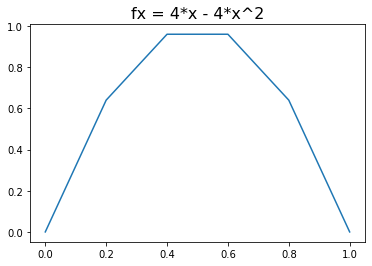

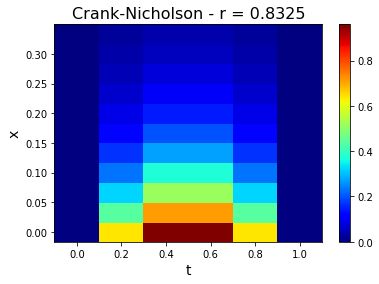

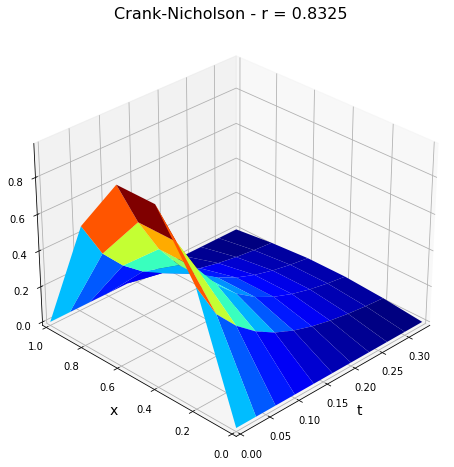

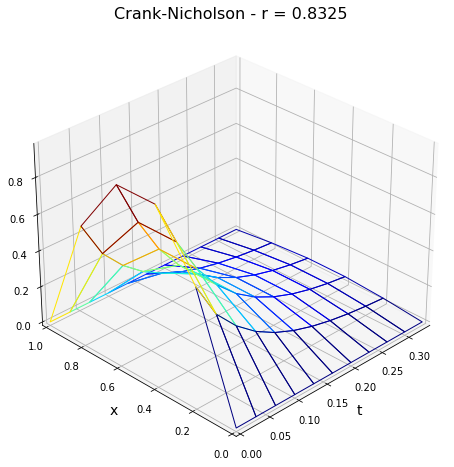

In [126]:
T, X, u =heat_cn()

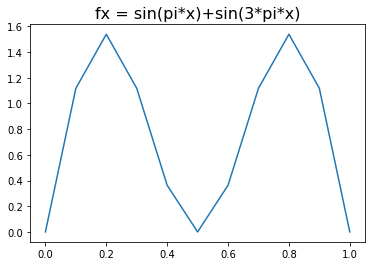

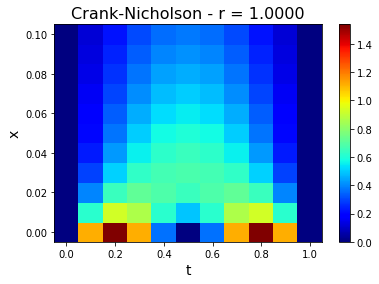

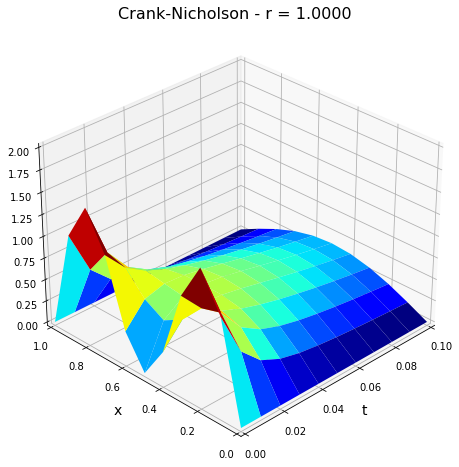

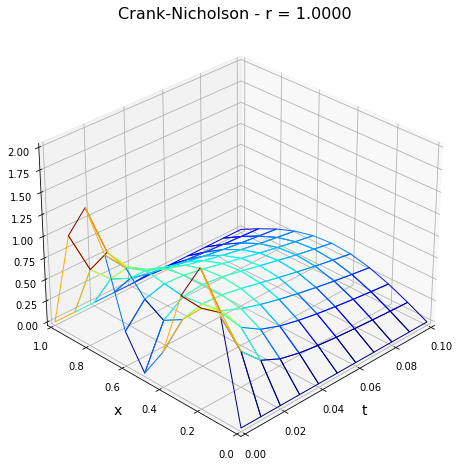

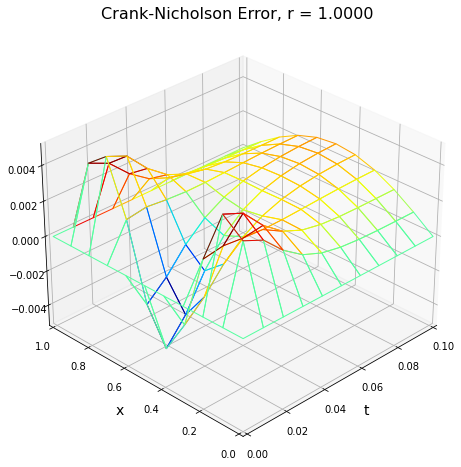

In [127]:
analytic = lambda x,t : np.exp(-np.pi**2*t)*np.sin(np.pi*x) + np.exp(-9*np.pi**2*t)*np.sin(3*np.pi*x) 
heat_cn(T=0.1, N=10, sin=True, analytic=analytic, zlims=[0, 2], zlims2=[-5e-3, 5e-3]);


